In [1]:
import os
import re
import glob
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
# Set global matplotlib defaults: Nimbus Roman + dpi=300
plt.rcParams["font.family"] = "Nimbus Roman"
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300

In [3]:
WORK_DIR = "/home/yyuan/ICB_TCE/"
ITER_DIR = os.path.join(WORK_DIR, "iter_results")
SUMMARY_DIR = os.path.join(ITER_DIR, "summaries")
os.makedirs(SUMMARY_DIR, exist_ok=True)
FIG_DIR = os.path.join(SUMMARY_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)

EPS = 1e-12  # for fold-change stability when abs(ablation)==0

VALUE_FWD = os.path.join(SUMMARY_DIR, "value_change_fwd.csv")
VALUE_BWD = os.path.join(SUMMARY_DIR, "value_change_bwd.csv")
FC_FWD = os.path.join(SUMMARY_DIR, "fold_change_fwd.csv")
FC_BWD = os.path.join(SUMMARY_DIR, "fold_change_bwd.csv")

In [4]:
def pick_gene_col(df: pd.DataFrame) -> str:
    candidates = ["gene_symbol", "symbol", "gene", "feature_name", "feature", "name"]
    for c in candidates:
        if c in df.columns:
            return c
    # fallback: first non-numeric column; else first column
    nonnum = [c for c in df.columns if not pd.api.types.is_numeric_dtype(df[c])]
    return nonnum[0] if nonnum else df.columns[0]


def pick_value_col(df: pd.DataFrame, gene_col: str) -> str:
    numeric_cols = [c for c in df.columns if c != gene_col and pd.api.types.is_numeric_dtype(df[c])]
    if not numeric_cols:
        raise ValueError(f"No numeric value column found (gene_col={gene_col}). Columns: {list(df.columns)}")

    # prefer drift-ish column names if present
    preferred = []
    for c in numeric_cols:
        cl = c.lower()
        if "drift" in cl or "value" in cl or "score" in cl:
            preferred.append(c)
    return preferred[0] if preferred else numeric_cols[0]


def seed_from_run_dir(run_dir: str) -> int:
    base = os.path.basename(run_dir.rstrip("/"))
    m = re.search(r"run_(\d+)", base)
    if not m:
        raise ValueError(f"Cannot parse seed from run dir: {run_dir}")
    return int(m.group(1))


def load_two_tables(orig_path: str, abl_path: str):
    df_o = pd.read_csv(orig_path)
    df_a = pd.read_csv(abl_path)

    gene_o = pick_gene_col(df_o)
    gene_a = pick_gene_col(df_a)
    val_o = pick_value_col(df_o, gene_o)
    val_a = pick_value_col(df_a, gene_a)

    df_o = df_o[[gene_o, val_o]].rename(columns={gene_o: "gene", val_o: "orig"})
    df_a = df_a[[gene_a, val_a]].rename(columns={gene_a: "gene", val_a: "abl"})

    merged = df_o.merge(df_a, on="gene", how="inner")
    return merged

def save(df_list, filename: str):
    if not df_list:
        print(f"[warn] no rows for {filename}, not writing")
        return
    out = pd.concat(df_list, ignore_index=True)
    out_path = os.path.join(SUMMARY_DIR, filename)
    out.to_csv(out_path, index=False)
    print(f"[ok] wrote {out_path} ({len(out):,} rows)")

In [5]:
run_dirs = sorted(glob.glob(os.path.join(ITER_DIR, "run_*")))
if not run_dirs:
    raise SystemExit(f"No run_* folders found under: {ITER_DIR}")

value_fwd_all = []
value_bwd_all = []
fold_fwd_all = []
fold_bwd_all = []

for run_dir in run_dirs:
    seed = seed_from_run_dir(run_dir)
    paths = {
        "fwd": (
            os.path.join(run_dir, "drift_genes_forward_original.csv"),
            os.path.join(run_dir, "drift_genes_forward_ablation.csv"),
        ),
        "bwd": (
            os.path.join(run_dir, "drift_genes_backward_original.csv"),
            os.path.join(run_dir, "drift_genes_backward_ablation.csv"),
        ),
    }

    for tag, (p_orig, p_abl) in paths.items():
        if not (os.path.exists(p_orig) and os.path.exists(p_abl)):
            print(f"[skip] seed={seed:03d} tag={tag} missing files")
            continue

        merged = load_two_tables(p_orig, p_abl)
        merged.insert(0, "seed", seed)

        # value change keeps sign: (original - ablation)
        v = merged.copy()
        v["value_change"] = v["orig"] - v["abl"]
        v = v[["seed", "gene", "orig", "abl", "value_change"]]

        # fold change: keep BOTH raw and abs-based variants
        f = merged.copy()
        f["orig_abs"] = np.abs(f["orig"].to_numpy())
        f["abl_abs"] = np.abs(f["abl"].to_numpy())

        # abs-based (always positive, magnitude-only)
        f["fold_change_abs"] = (f["orig_abs"] + EPS) / (f["abl_abs"] + EPS)

        # raw (signed) ratio; avoid divide-by-zero blowups by setting near-zero denom to NaN
        denom = f["abl"].to_numpy(dtype=float)
        num = f["orig"].to_numpy(dtype=float)
        safe = np.abs(denom) > EPS
        fc_raw = np.full_like(num, np.nan, dtype=float)
        fc_raw[safe] = num[safe] / denom[safe]
        f["fold_change_raw"] = fc_raw

        f = f[["seed", "gene", "orig", "abl", "orig_abs", "abl_abs", "fold_change_abs", "fold_change_raw"]]

        if tag == "fwd":
            value_fwd_all.append(v)
            fold_fwd_all.append(f)
        else:
            value_bwd_all.append(v)
            fold_bwd_all.append(f)


save(value_fwd_all, "value_change_fwd.csv")
save(value_bwd_all, "value_change_bwd.csv")
save(fold_fwd_all, "fold_change_fwd.csv")
save(fold_bwd_all, "fold_change_bwd.csv")

[ok] wrote /home/yyuan/ICB_TCE/iter_results/summaries/value_change_fwd.csv (300,000 rows)
[ok] wrote /home/yyuan/ICB_TCE/iter_results/summaries/value_change_bwd.csv (300,000 rows)
[ok] wrote /home/yyuan/ICB_TCE/iter_results/summaries/fold_change_fwd.csv (300,000 rows)
[ok] wrote /home/yyuan/ICB_TCE/iter_results/summaries/fold_change_bwd.csv (300,000 rows)


In [9]:
def lower_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [str(c).strip() for c in df.columns]
    return df


def pick_col(df, candidates):
    cols_l = {c.lower(): c for c in df.columns}
    for cand in candidates:
        for k, orig in cols_l.items():
            if k == cand.lower() or k.endswith(cand.lower()) or cand.lower() in k:
                return orig
    return None


def run_cols(df: pd.DataFrame):
    # Heuristic: columns that look like run_001, seed_1, r12, or pure integers
    run_like = []
    for c in df.columns:
        cl = str(c).lower()
        if re.fullmatch(r"(run|seed)[_\-]?\d+", cl) or re.fullmatch(r"r\d+", cl) or re.fullmatch(r"\d+", cl):
            run_like.append(c)
    return run_like


def bh_fdr(pvals: np.ndarray) -> np.ndarray:
    p = np.asarray(pvals, dtype=float)
    n = np.isfinite(p).sum()
    out = np.full_like(p, np.nan, dtype=float)
    if n == 0:
        return out

    idx = np.where(np.isfinite(p))[0]
    pv = p[idx]
    order = np.argsort(pv)
    ranked = pv[order]
    m = len(ranked)

    q = ranked * m / (np.arange(1, m + 1))
    q = np.minimum.accumulate(q[::-1])[::-1]
    q = np.clip(q, 0, 1)

    out_idx = np.empty_like(order)
    out_idx[order] = np.arange(m)
    out[idx] = q[out_idx]
    return out


def load_value_change_stats(path: str) -> pd.DataFrame:
    """
    Returns per-gene (magnitude-ready):
      gene, mean, mean_sq_across_runs, var_across_runs

    Supports either:
      - long: gene + run + value columns
      - wide: gene + many run columns
      - already aggregated: contains mean/var (and optionally mean_sq) columns
    """
    df = lower_cols(pd.read_csv(path))

    gene_col = pick_col(df, ["gene", "symbol", "gene_symbol", "feature", "feature_name", "genes"])
    if gene_col is None:
        gene_col = df.columns[0]  # fallback

    # Case A: already aggregated
    mean_col = pick_col(df, ["mean", "avg", "average"])
    var_col = pick_col(df, ["var_across_runs", "var", "variance"])
    mean_sq_col = pick_col(df, ["mean_sq", "mean_square", "mean_sq_across_runs", "meansq"])
    if mean_col is not None and var_col is not None:
        out = df[[gene_col, mean_col, var_col] + ([mean_sq_col] if mean_sq_col else [])].copy()
        out = out.rename(columns={gene_col: "gene", mean_col: "mean", var_col: "var_across_runs"})
        if mean_sq_col is not None:
            out = out.rename(columns={mean_sq_col: "mean_sq_across_runs"})
        else:
            out["mean_sq_across_runs"] = np.nan
        return out[["gene", "mean", "mean_sq_across_runs", "var_across_runs"]]

    # Case B: long format
    run_col = pick_col(df, ["run", "seed", "replicate"])
    val_col = pick_col(df, ["value_change", "value", "delta", "diff", "change"])
    if run_col is not None and val_col is not None:
        df[val_col] = pd.to_numeric(df[val_col], errors="coerce")
        g = df.groupby(gene_col, dropna=False)[val_col]
        out = pd.DataFrame({
            "gene": g.mean().index.astype(str),
            "mean": g.mean().values,
            "mean_sq_across_runs": g.apply(lambda x: np.nanmean(np.square(x.values))).values,
            "var_across_runs": g.var(ddof=1).values,
        })
        return out

    # Case C: wide format
    run_cols_ = run_cols(df)
    if len(run_cols_) == 0:
        # fallback: treat all non-gene numeric cols as runs
        run_cols_ = [c for c in df.columns if c != gene_col and pd.api.types.is_numeric_dtype(df[c])]

    if len(run_cols_) == 0:
        raise ValueError(f"Could not infer per-run columns in: {path}")

    vals = df[run_cols_].apply(pd.to_numeric, errors="coerce")
    v = vals.to_numpy(dtype=float)
    out = pd.DataFrame({
        "gene": df[gene_col].astype(str).values,
        "mean": np.nanmean(v, axis=1),
        "mean_sq_across_runs": np.nanmean(np.square(v), axis=1),
        "var_across_runs": np.nanvar(v, axis=1, ddof=1),
    })
    return out


def plot_mean_square_over_variance_top(
    stats_df: pd.DataFrame,
    title: str,
    outpath: str,
    n_top: int = 40,
    var_floor: float = 1e-10,
 ):
    s = stats_df.copy()
    s = s.replace([np.inf, -np.inf], np.nan)
    s = s.dropna(subset=["mean", "var_across_runs"])
    s = s[s["var_across_runs"] > var_floor].copy()

    # magnitude-only score: mean^2 / variance (no sign)
    s["ms_over_var"] = (s["mean"] ** 2) / s["var_across_runs"]
    s = s.replace([np.inf, -np.inf], np.nan).dropna(subset=["ms_over_var"])
    if s.empty:
        raise ValueError("No valid ms_over_var values after filtering.")

    # Return in the same order as shown in the plot: highest score first.
    sel = s.sort_values("ms_over_var", ascending=False).head(n_top).copy()

    fig, ax = plt.subplots(figsize=(10, max(6, 0.22 * len(sel))))
    ax.barh(sel["gene"], sel["ms_over_var"], color="#1f77b4", alpha=0.9)
    ax.invert_yaxis()  # put the first row (highest) at the top
    ax.set_title(title)
    ax.set_xlabel("mean(value_change)^2 / Var(value_change) across runs")
    ax.set_ylabel("")
    plt.tight_layout()
    fig.savefig(outpath, dpi=300)
    plt.show()
    return sel


def load_fold_change_for_volcano_with_fdr(
    path: str,
    eps: float = 1e-12,
 ) -> pd.DataFrame:
    """
    Volcano inputs (sign-free):
      d_run = log2(|orig| + eps) - log2(|abl| + eps)
      x-axis = mean(d_run) across runs
      y-axis = -log10(FDR) from one-sample t-test of d_run vs 0 across runs (BH-corrected)

    Returns only core columns (no flip-rate, no diagnostic extras).
    """
    df = lower_cols(pd.read_csv(path))
    gene_col = pick_col(df, ["gene", "symbol", "gene_symbol", "feature", "feature_name", "genes"]) or df.columns[0]
    run_col = pick_col(df, ["run", "seed", "replicate"])
    orig_col = pick_col(df, ["orig", "original"])
    abl_col = pick_col(df, ["abl", "ablation"])

    if run_col is None or orig_col is None or abl_col is None:
        raise ValueError(
            "Expected run/seed, orig, and abl columns. "
            f"Found: run_col={run_col}, orig_col={orig_col}, abl_col={abl_col}. "
            f"Columns: {list(df.columns)}"
        )

    df = df[[gene_col, run_col, orig_col, abl_col]].copy()
    df[orig_col] = pd.to_numeric(df[orig_col], errors="coerce")
    df[abl_col] = pd.to_numeric(df[abl_col], errors="coerce")
    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=[orig_col, abl_col])

    df["log2_mag_run"] = np.log2(df[orig_col].abs() + eps) - np.log2(df[abl_col].abs() + eps)

    g = df.groupby(gene_col, dropna=False)
    g_d = g["log2_mag_run"]

    n_runs = g_d.size()
    mean_d = g_d.mean()
    std_d = g_d.std(ddof=1)
    min_d = g_d.min()
    max_d = g_d.max()

    idx = mean_d.index
    out = pd.DataFrame({
        "gene": idx.astype(str),
        "n_runs": n_runs.reindex(idx).values,
        "mean_log2_mag_run": mean_d.reindex(idx).values,
        "std_log2_mag_run": std_d.reindex(idx).values,
        "min_log2_mag_run": min_d.reindex(idx).values,
        "max_log2_mag_run": max_d.reindex(idx).values,
    })

    def _pval_from_d(x: pd.Series) -> float:
        v = x.dropna().values
        if v.size < 2:
            return np.nan
        if np.allclose(v, v[0]):
            return 1.0 if np.isclose(v[0], 0.0) else 0.0
        return float(stats.ttest_1samp(v, popmean=0.0, nan_policy="omit").pvalue)

    pvals = g_d.apply(_pval_from_d)
    out["fdr"] = bh_fdr(pvals.reindex(idx).values)
    out["neglog10_fdr"] = -np.log10(out["fdr"].clip(lower=1e-300))

    return out


def plot_volcano(
    df: pd.DataFrame,
    title: str,
    outpath: str,
    label_top: int = 15,
    x_col: str = "mean_log2_mag_run",
 ):
    d = df.copy()
    d = d.replace([np.inf, -np.inf], np.nan)
    d = d.dropna(subset=[x_col, "neglog10_fdr"])

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(d[x_col], d["neglog10_fdr"], s=10, alpha=0.6, linewidths=0)

    ax.set_title(title)
    if x_col == "mean_log2_mag_run":
        xlabel = "mean(log2(|orig|+eps) - log2(|abl|+eps)) across runs"
    else:
        xlabel = x_col
    ax.set_xlabel(xlabel)
    ax.set_ylabel("-log10(FDR)")
    ax.axvline(0, color="black", linewidth=1, alpha=0.5)

    d2 = d.sort_values("neglog10_fdr", ascending=False).head(label_top)
    for _, r in d2.iterrows():
        ax.annotate(
            str(r["gene"]),
            (r[x_col], r["neglog10_fdr"]),
            textcoords="offset points",
            xytext=(4, 4),
            fontsize=8,
        )

    plt.tight_layout()
    fig.savefig(outpath, dpi=300)
    plt.show()

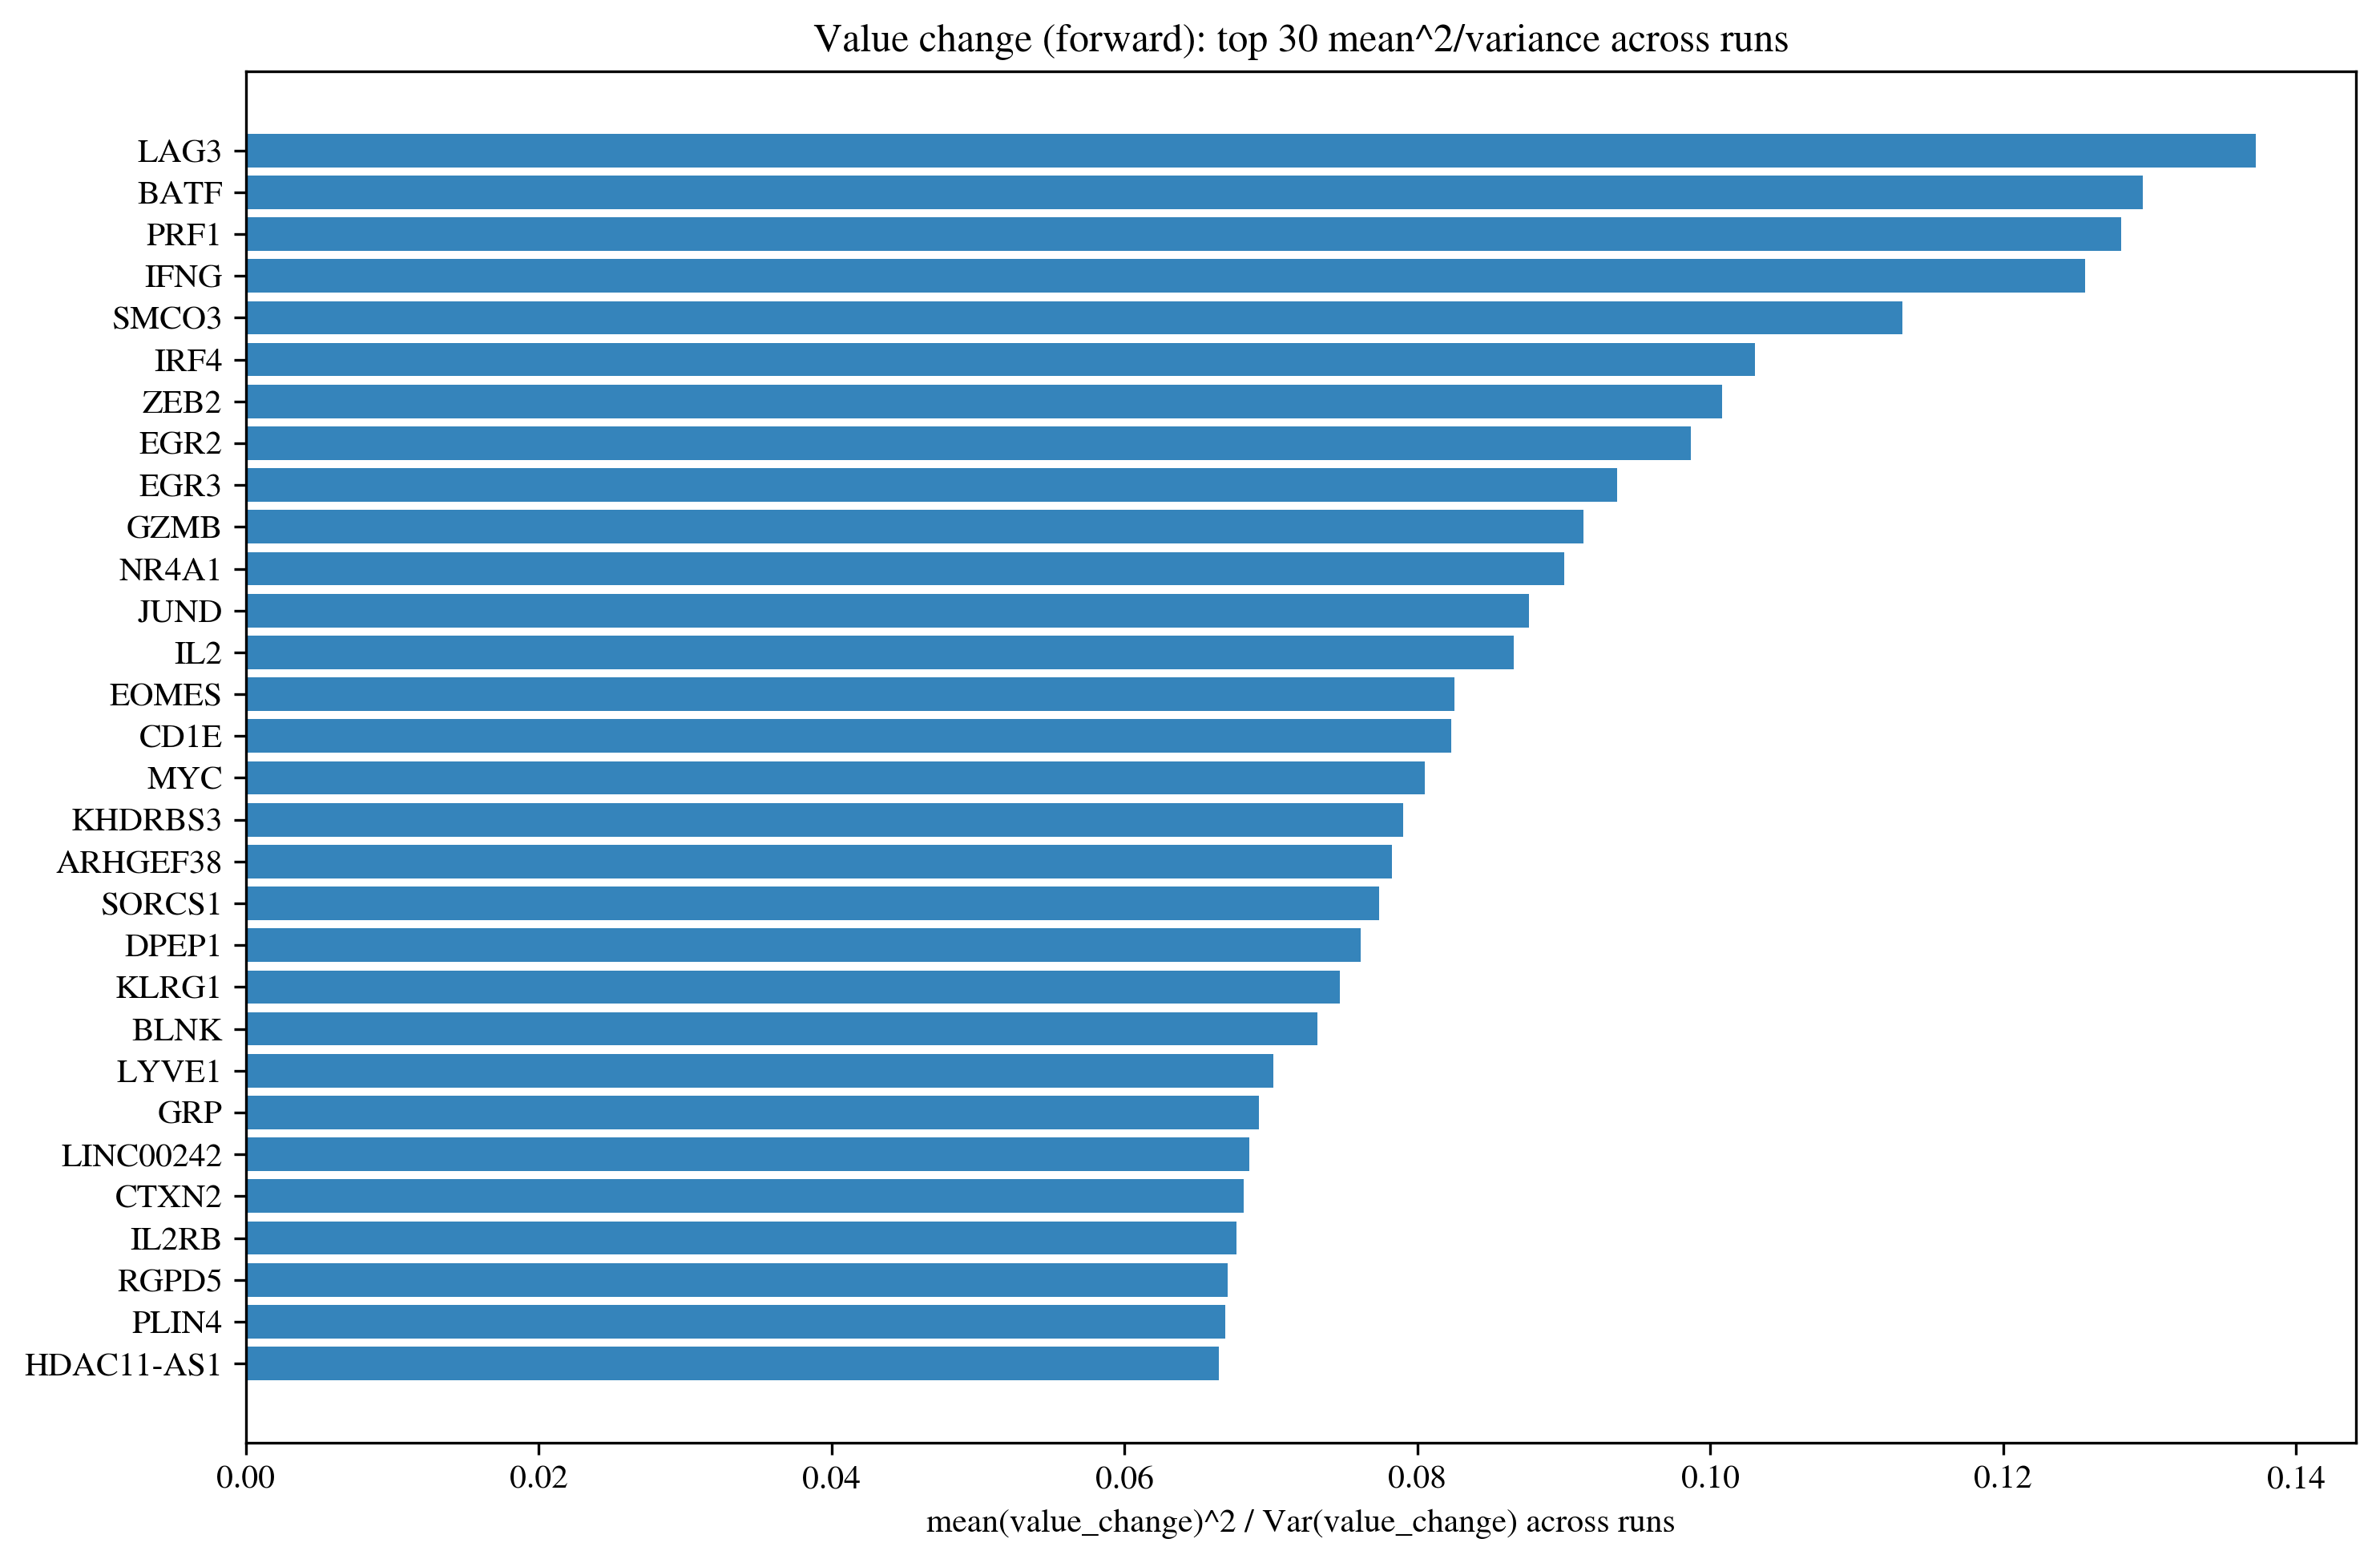

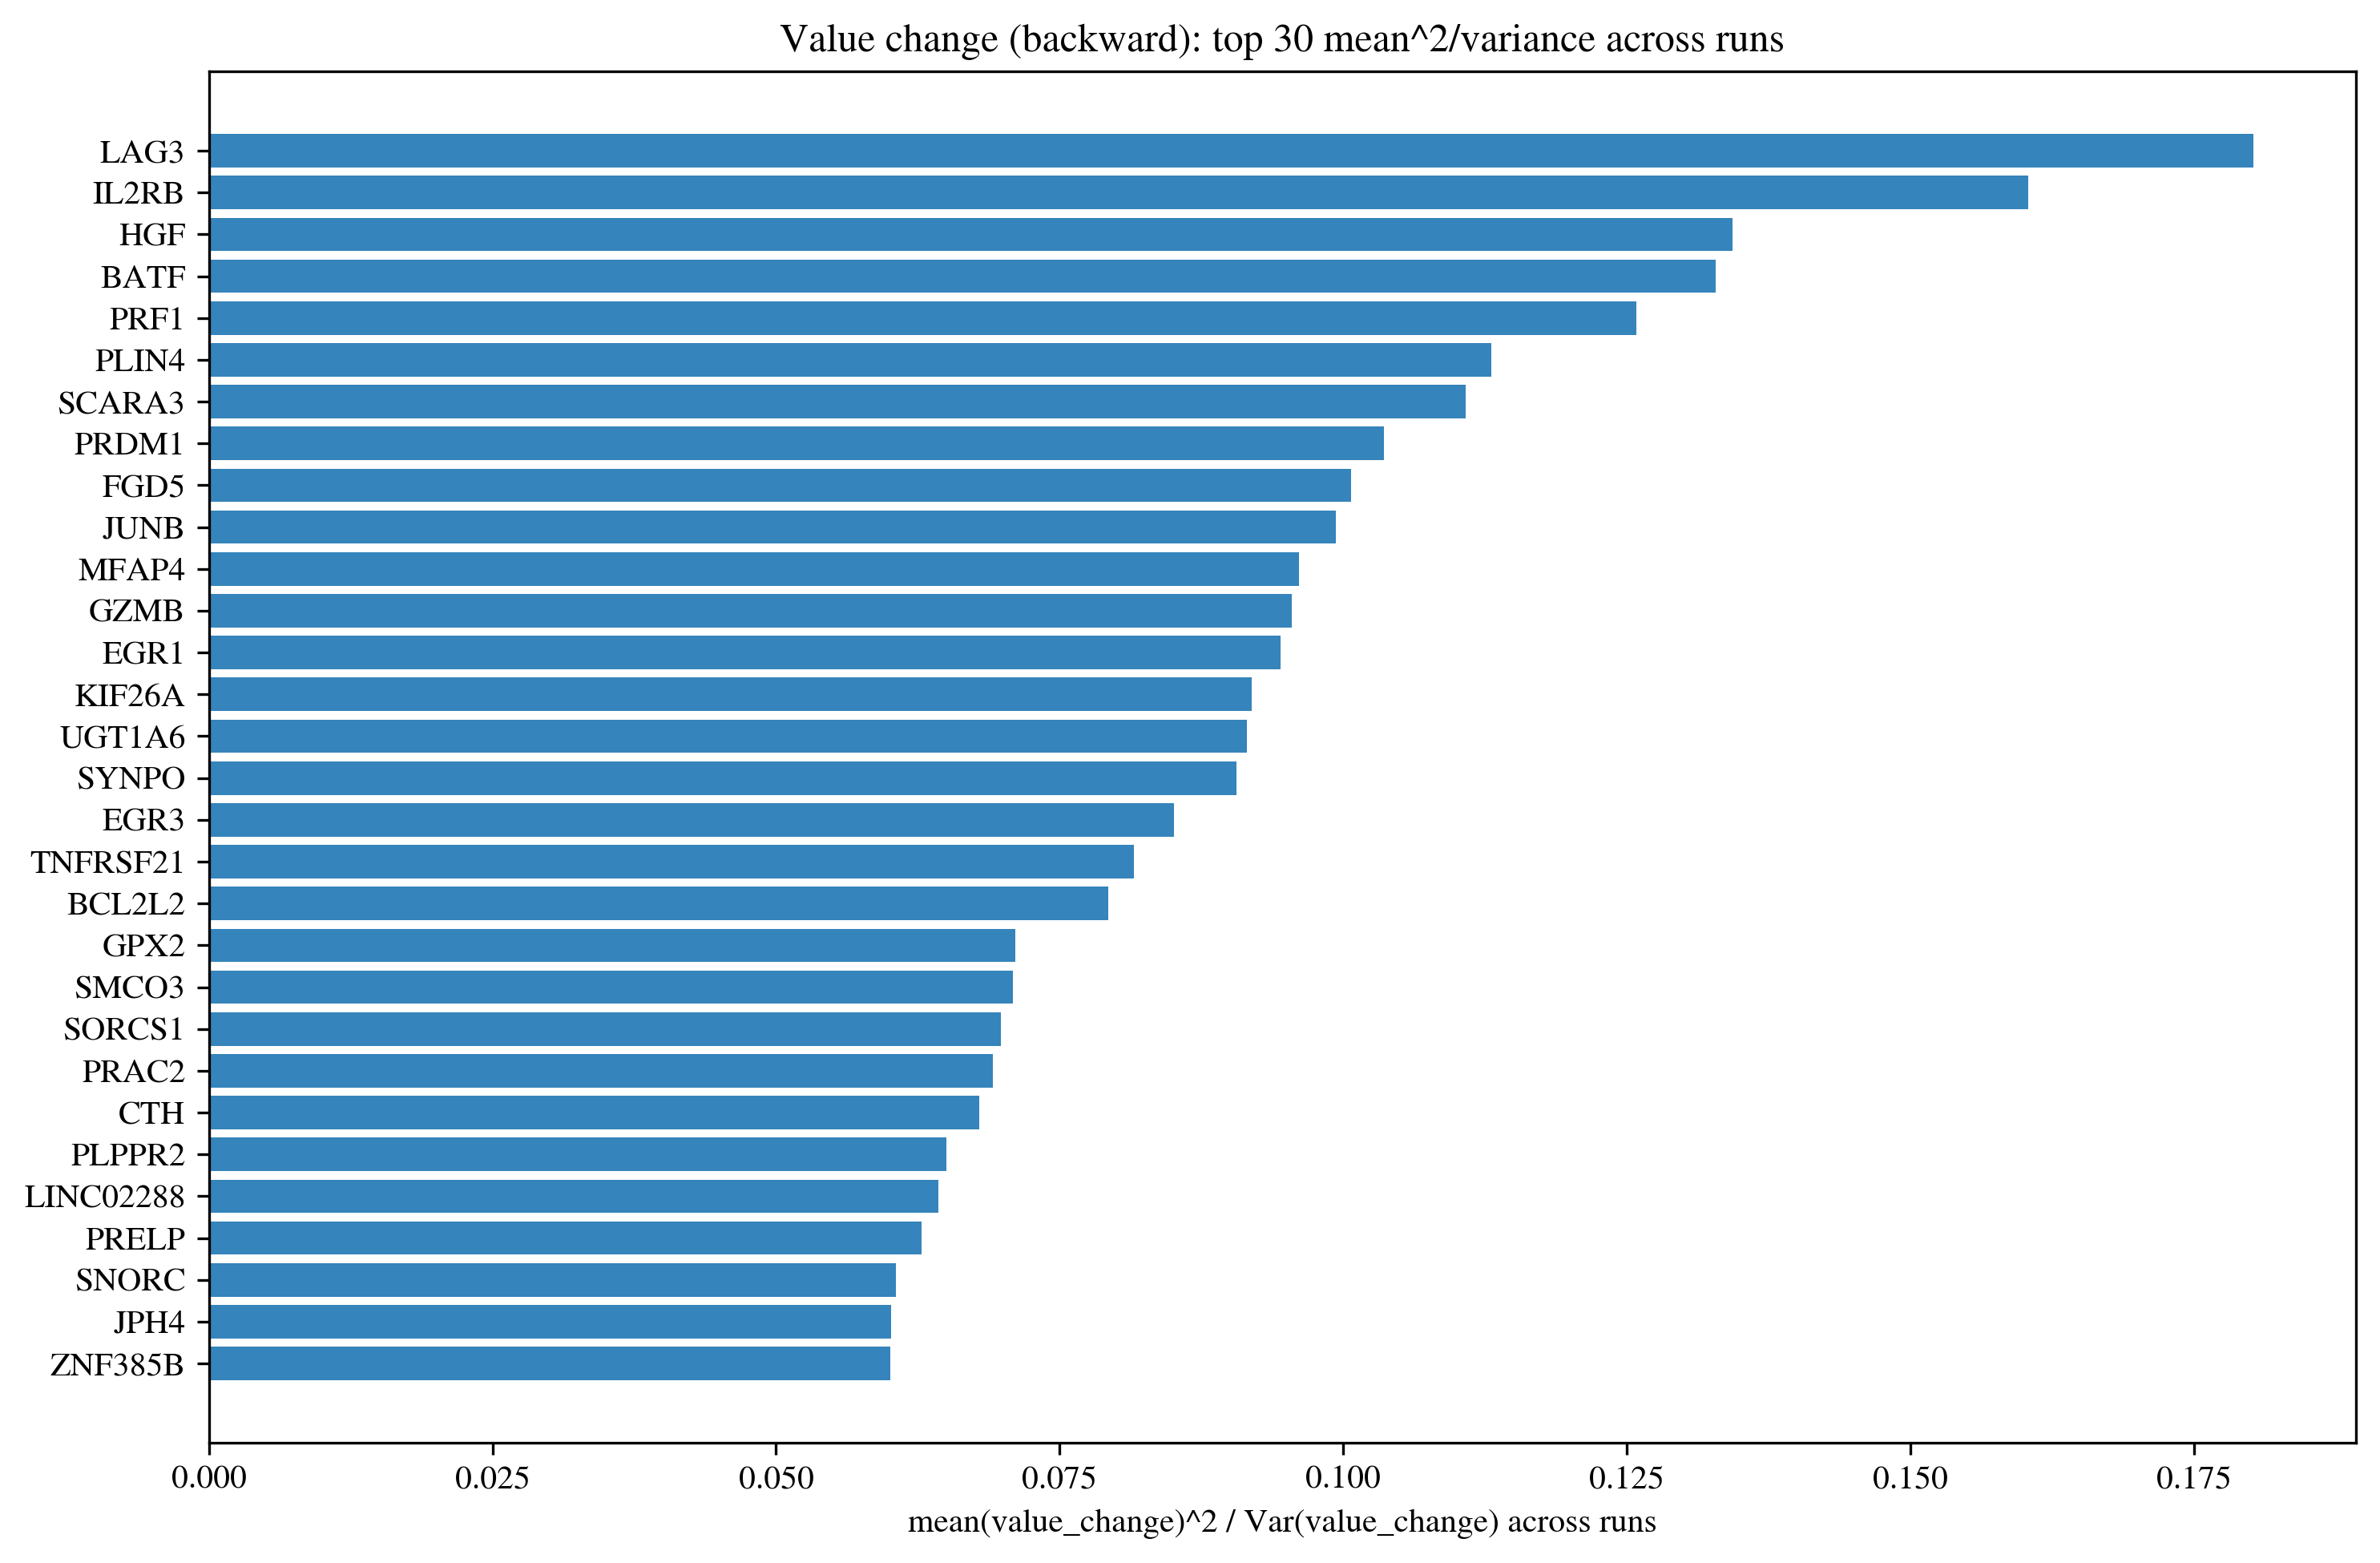

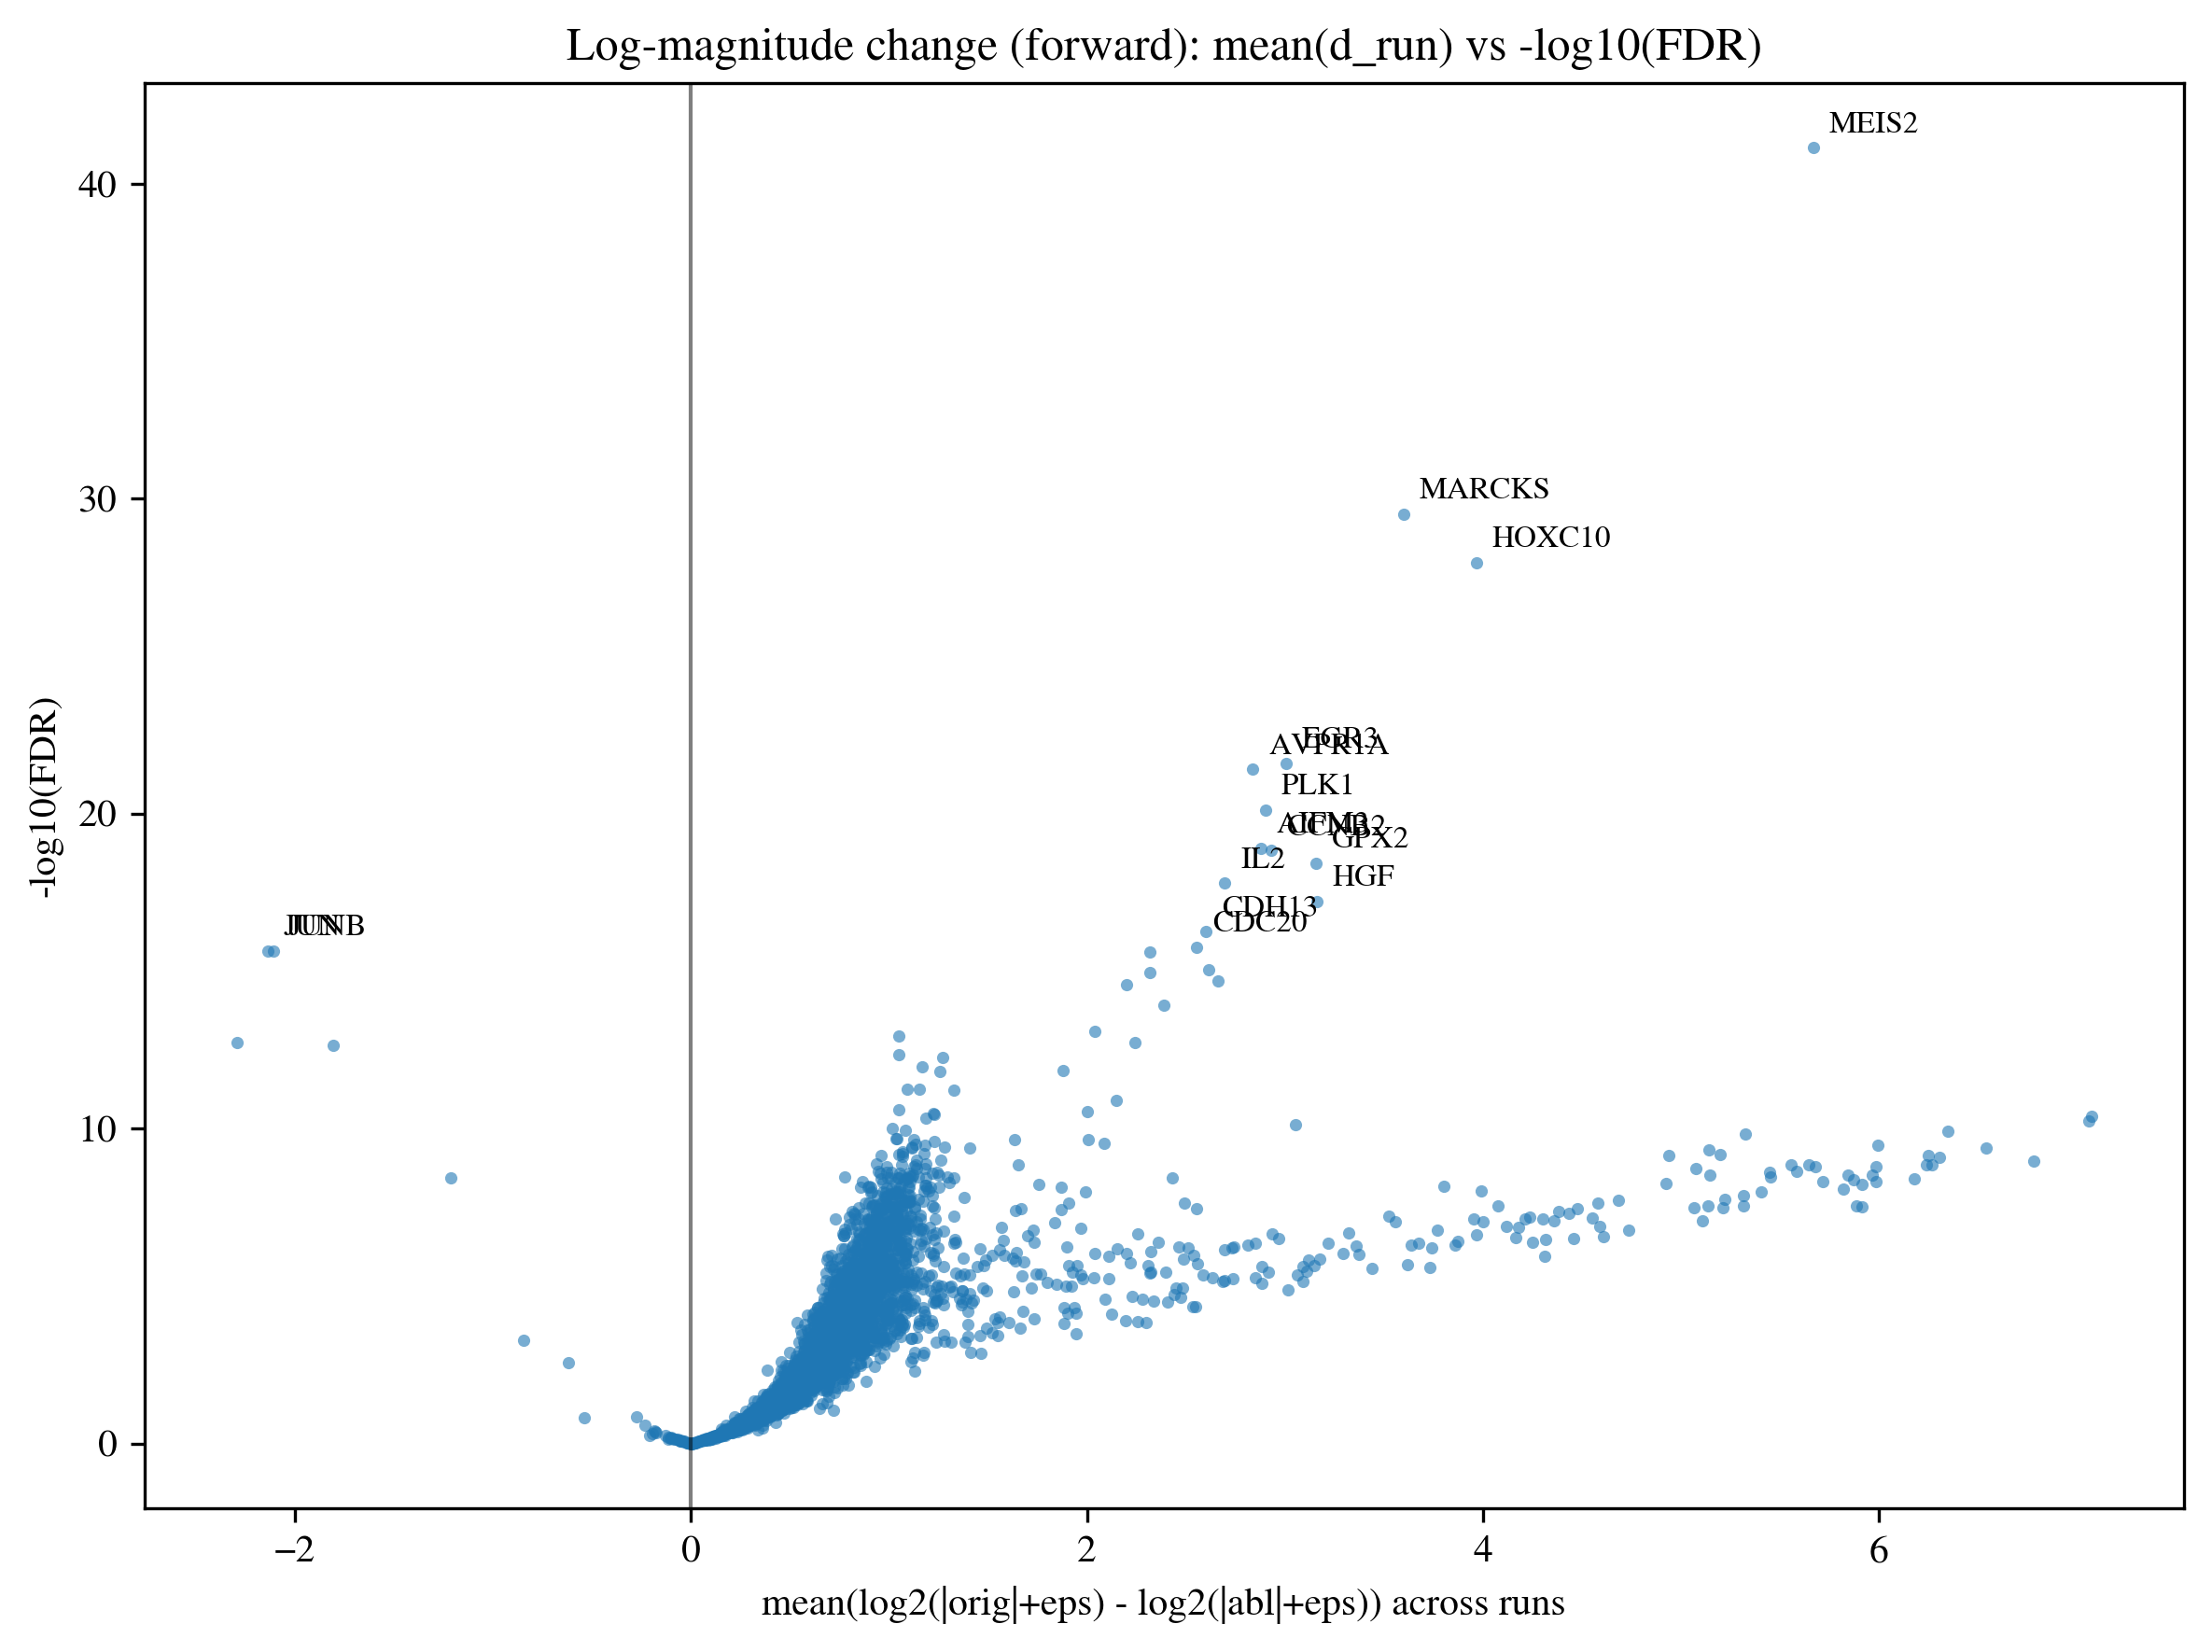

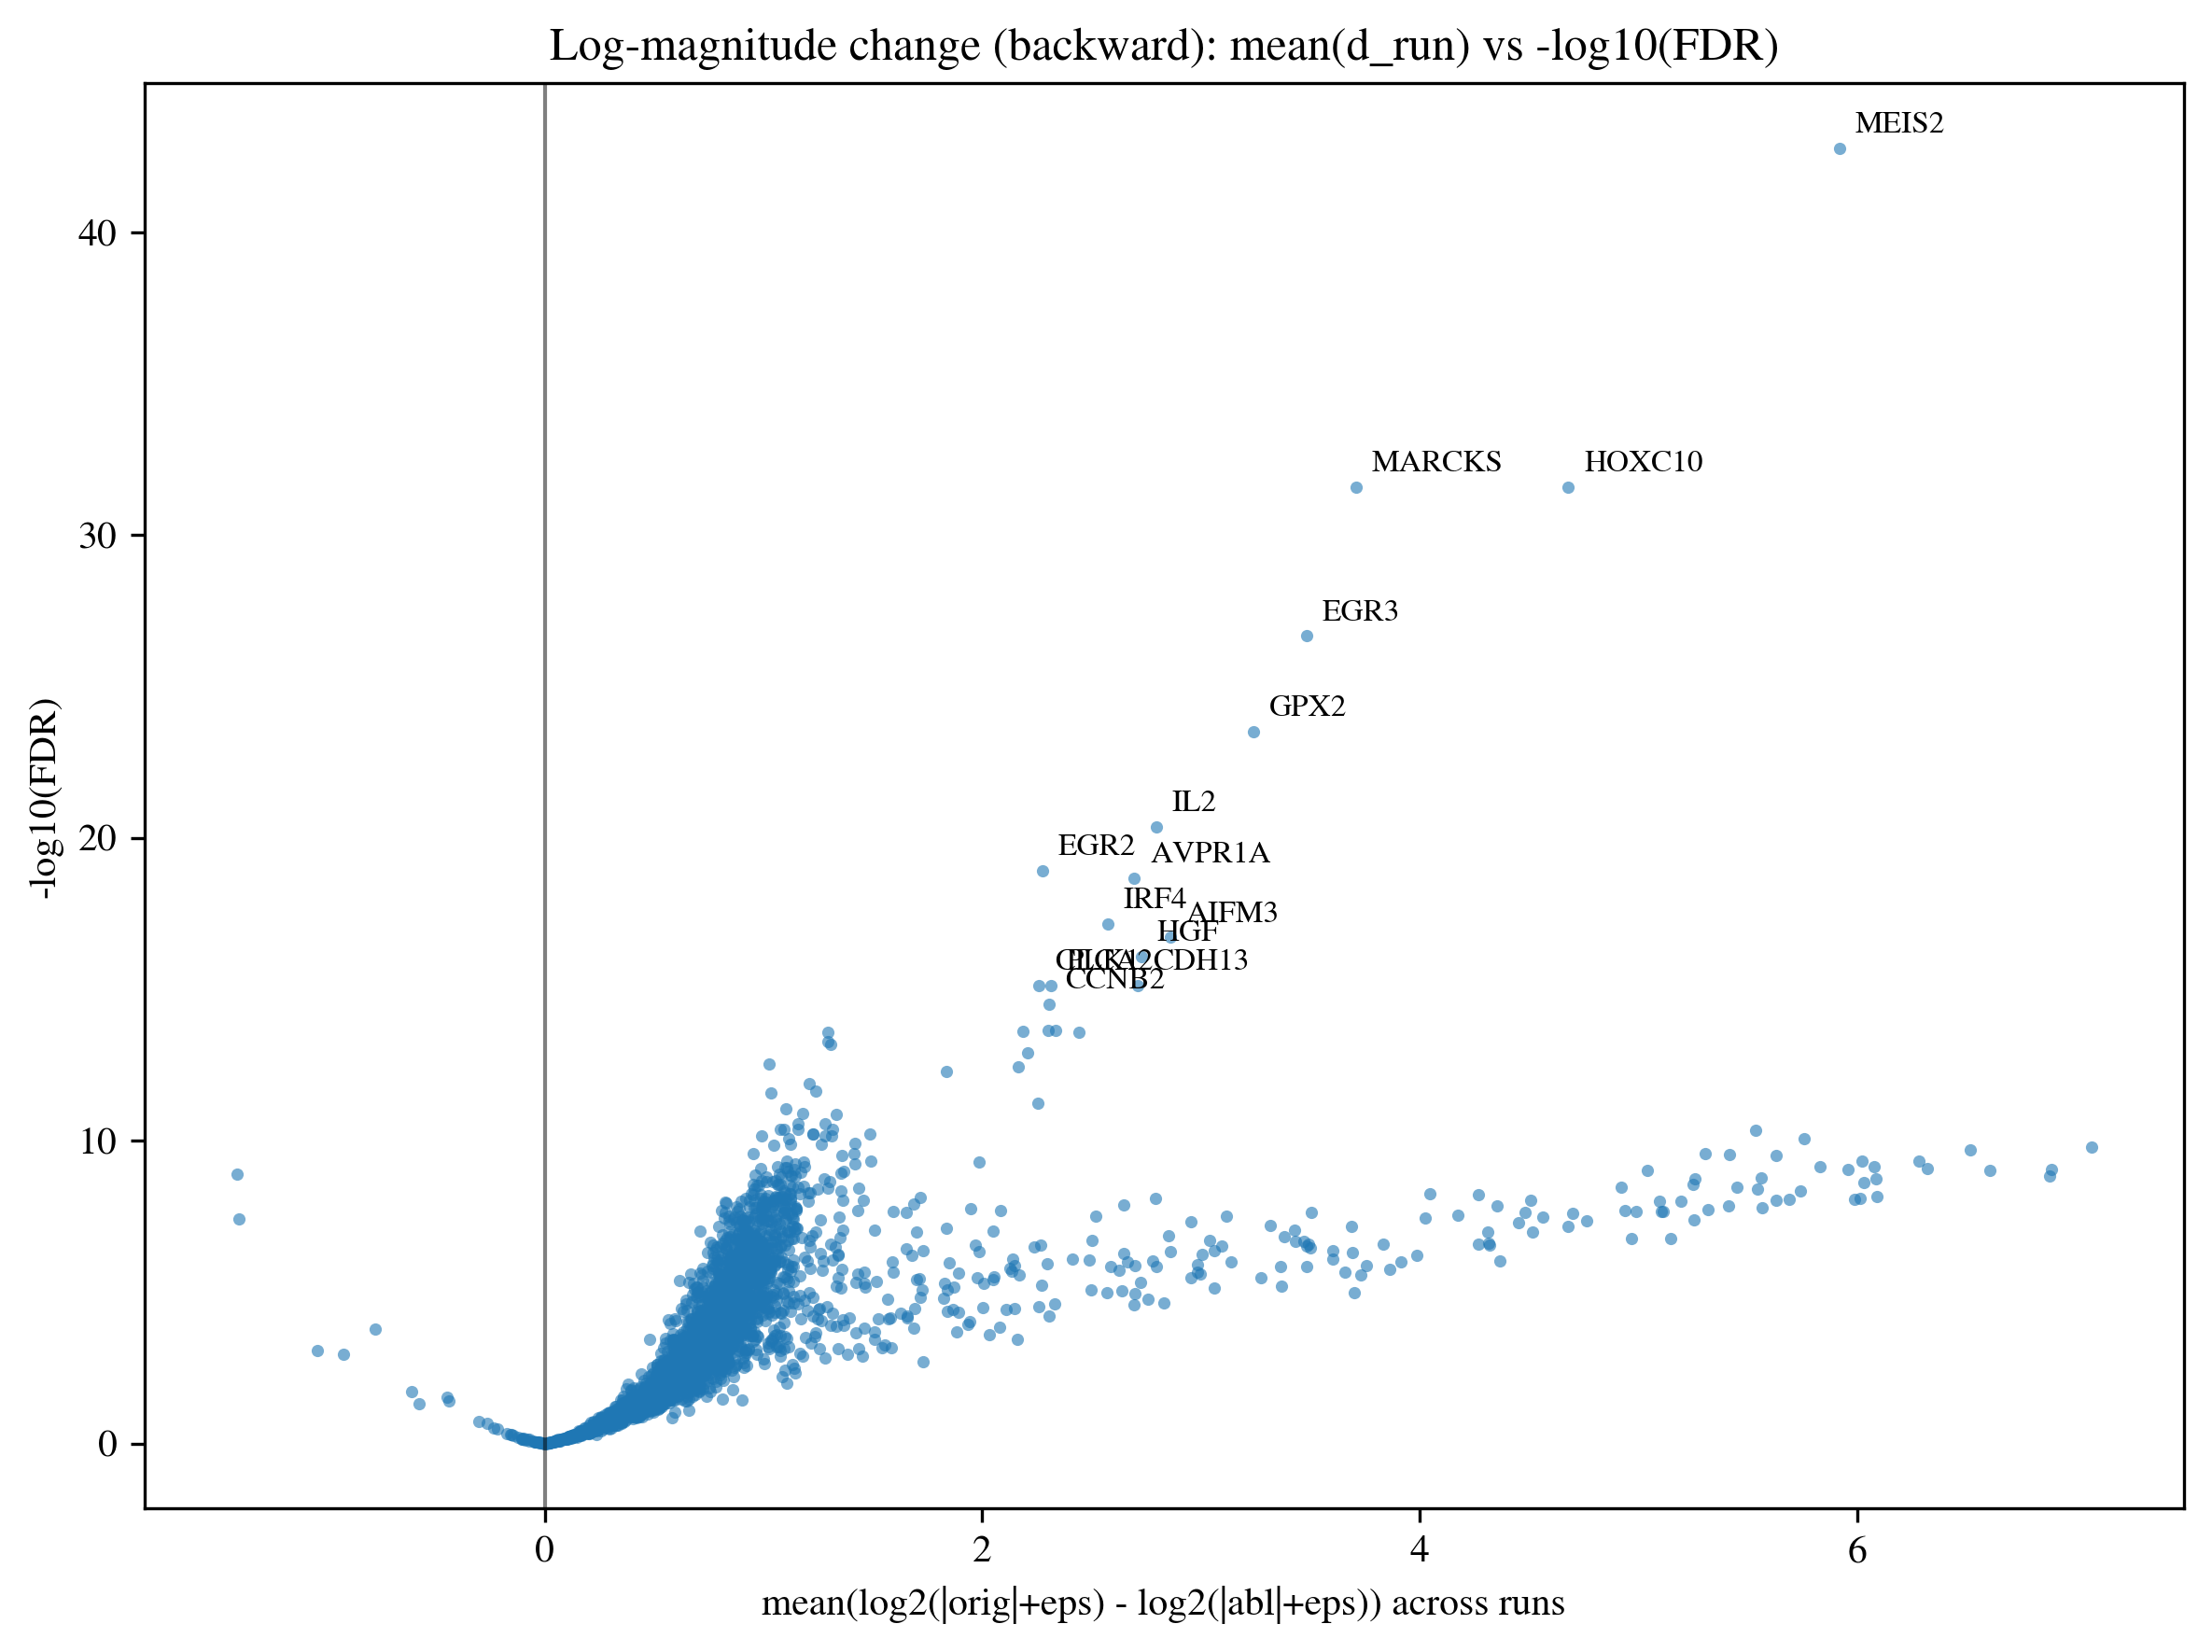

Saved figures to: /home/yyuan/ICB_TCE/iter_results/summaries/figures
Value-change top genes (forward):


,gene,mean,mean_sq_across_runs,var_across_runs,ms_over_var
1444,LAG3,-0.011472,1.081065e-03,9.590472e-04,0.137228
215,BATF,-0.009503,7.803850e-04,6.970469e-04,0.129559
2094,PRF1,-0.009984,8.704514e-04,7.785578e-04,0.128031
1176,IFNG,-0.005942,3.136689e-04,2.811713e-04,0.125579
2451,SMCO3,-0.000028,7.878120e-09,7.141714e-09,0.113113
1326,IRF4,-0.005545,3.261561e-04,2.983966e-04,0.103029
2957,ZEB2,-0.005400,3.155148e-04,2.892503e-04,0.100802
738,EGR2,-0.005295,3.093656e-04,2.841754e-04,0.098643
739,EGR3,-0.005354,3.317703e-04,3.061627e-04,0.093641
1055,GZMB,-0.012061,1.721939e-03,1.592383e-03,0.091360


Value-change top genes (backward):


,gene,mean,mean_sq_across_runs,var_across_runs,ms_over_var
1444,LAG3,-0.011371,8.393738e-04,7.172580e-04,0.180254
1301,IL2RB,-0.010048,7.241774e-04,6.295177e-04,0.160369
1088,HGF,-0.000275,6.313262e-07,5.615414e-07,0.134274
215,BATF,-0.009902,8.290142e-04,7.383399e-04,0.132808
2094,PRF1,-0.009872,8.640647e-04,7.743453e-04,0.125865
2032,PLIN4,0.000050,2.423055e-08,2.196721e-08,0.113033
2310,SCARA3,0.000067,4.518646e-08,4.105032e-08,0.110758
2091,PRDM1,-0.010812,1.233905e-03,1.128299e-03,0.103597
866,FGD5,0.000062,4.136072e-08,3.792094e-08,0.100709
1364,JUNB,-0.044861,2.206184e-02,2.025190e-02,0.099372


Volcano preview (forward):


,gene,mean_log2_mag_run,fdr
1660,MEIS2,5.667285,7.357067e-42
1637,MARCKS,3.599948,3.102215e-30
1116,HOXC10,3.967961,1.092093e-28
739,EGR3,3.006765,2.498999e-22
202,AVPR1A,2.837567,3.897926e-22
2034,PLK1,2.902344,7.594222e-21
85,AIFM3,2.879408,1.282908e-19
356,CCNB2,2.927850,1.488849e-19
1018,GPX2,3.158579,3.717481e-19
1293,IL2,2.696143,1.620202e-18


Volcano preview (backward):


,gene,mean_log2_mag_run,fdr
1660,MEIS2,5.918548,1.659832e-43
1116,HOXC10,4.679570,2.561901e-32
1637,MARCKS,3.708964,2.561901e-32
739,EGR3,3.482068,2.104596e-27
1018,GPX2,3.240983,3.040490e-24
1293,IL2,2.794647,4.237537e-21
738,EGR2,2.274834,1.181454e-19
202,AVPR1A,2.695430,2.066044e-19
1326,IRF4,2.573043,6.923980e-18
85,AIFM3,2.861310,1.884165e-17


In [10]:
# -------------------------
# Value change (sign-free): mean^2 / variance across runs
# -------------------------
vc_fwd = load_value_change_stats(VALUE_FWD)
vc_bwd = load_value_change_stats(VALUE_BWD)

sel_fwd = plot_mean_square_over_variance_top(
    vc_fwd,
    title="Value change (forward): top 30 mean^2/variance across runs",
    outpath=os.path.join(FIG_DIR, "value_change_fwd_mean2_over_var_top30.png"),
    n_top=30,
    var_floor=1e-10,
)

sel_bwd = plot_mean_square_over_variance_top(
    vc_bwd,
    title="Value change (backward): top 30 mean^2/variance across runs",
    outpath=os.path.join(FIG_DIR, "value_change_bwd_mean2_over_var_top30.png"),
    n_top=30,
    var_floor=1e-10,
)

# -------------------------
# Volcano (sign-free): no flip-rate, no color mapping, no diagnostic extras
# -------------------------
fc_fwd = load_fold_change_for_volcano_with_fdr(FC_FWD, eps=EPS)
fc_bwd = load_fold_change_for_volcano_with_fdr(FC_BWD, eps=EPS)

plot_volcano(
    fc_fwd,
    title="Log-magnitude change (forward): mean(d_run) vs -log10(FDR)",
    outpath=os.path.join(FIG_DIR, "fold_change_fwd_volcano.png"),
    label_top=15,
)

plot_volcano(
    fc_bwd,
    title="Log-magnitude change (backward): mean(d_run) vs -log10(FDR)",
    outpath=os.path.join(FIG_DIR, "fold_change_bwd_volcano.png"),
    label_top=15,
)

print("Saved figures to:", FIG_DIR)
print("Value-change top genes (forward):")
display(sel_fwd)
print("Value-change top genes (backward):")
display(sel_bwd)

print("Volcano preview (forward):")
display(
    fc_fwd.sort_values("neglog10_fdr", ascending=False).head(15)[
        ["gene", "mean_log2_mag_run", "fdr"]
    ]
)
print("Volcano preview (backward):")
display(
    fc_bwd.sort_values("neglog10_fdr", ascending=False).head(15)[
        ["gene", "mean_log2_mag_run", "fdr"]
    ]
)